<a href="https://colab.research.google.com/github/Seong-JiHyeon/Kaggle-Competition/blob/main/PredictFutureSales_%ED%95%84%EC%82%AC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/My Drive/market

/content/gdrive/My Drive/market


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
test = pd.read_csv('test.csv')
sales = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')

In [ ]:
sales['year'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%Y')) 
sales['month'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').month) 
sales['day'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').day) 

In [ ]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,02.01.2013,0,59,22154,999.00,1.0,2013,1,2
1,03.01.2013,0,25,2552,899.00,1.0,2013,1,3
2,05.01.2013,0,25,2552,899.00,-1.0,2013,1,5
3,06.01.2013,0,25,2554,1709.05,1.0,2013,1,6
4,15.01.2013,0,25,2555,1099.00,1.0,2013,1,15


In [ ]:
pip install holidays

In [ ]:
import holidays

holiday = []
for date in holidays.Russia(years=2013).items():
  holiday.append(np.array(date[0]))

for date in holidays.Russia(years=2014).items():
  holiday.append(np.array(date[0]))

for date in holidays.Russia(years=2015).items():
  holiday.append(np.array(date[0]))

holiday = pd.DataFrame(np.vstack(holiday), columns = ['date'], dtype=np.datetime64)
holiday['holiday'] = 1

In [ ]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     42 non-null     datetime64[ns]
 1   holiday  42 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 800.0 bytes


In [ ]:
holiday

,date,holiday
0,2013-01-01,1
1,2013-01-02,1
2,2013-01-03,1
3,2013-01-04,1
4,2013-01-05,1
5,2013-01-06,1
6,2013-01-07,1
7,2013-01-08,1
8,2013-02-23,1
9,2013-03-08,1


In [ ]:
holiday['date'] = pd.to_datetime(holiday['date'])

In [ ]:
holiday['year'] = pd.DatetimeIndex(holiday['date']).year
holiday['month'] = pd.DatetimeIndex(holiday['date']).month
holiday['day'] = pd.DatetimeIndex(holiday['date']).day

holiday

,date,holiday,year,month,day
0,2013-01-01,1,2013,1,1
1,2013-01-02,1,2013,1,2
2,2013-01-03,1,2013,1,3
3,2013-01-04,1,2013,1,4
4,2013-01-05,1,2013,1,5
5,2013-01-06,1,2013,1,6
6,2013-01-07,1,2013,1,7
7,2013-01-08,1,2013,1,8
8,2013-02-23,1,2013,2,23
9,2013-03-08,1,2013,3,8


In [ ]:
sales = sales.drop(columns=['date'])
sales

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,0,59,22154,999.00,1.0,2013,1,2
1,0,25,2552,899.00,1.0,2013,1,3
2,0,25,2552,899.00,-1.0,2013,1,5
3,0,25,2554,1709.05,1.0,2013,1,6
4,0,25,2555,1099.00,1.0,2013,1,15
...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015,10,10
2935845,33,25,7460,299.00,1.0,2015,10,9
2935846,33,25,7459,349.00,1.0,2015,10,14
2935847,33,25,7440,299.00,1.0,2015,10,22


In [ ]:
holiday = holiday.drop(columns=['date'])
holiday

,holiday,year,month,day
0,1,2013,1,1
1,1,2013,1,2
2,1,2013,1,3
3,1,2013,1,4
4,1,2013,1,5
5,1,2013,1,6
6,1,2013,1,7
7,1,2013,1,8
8,1,2013,2,23
9,1,2013,3,8


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_price      float64
 4   item_cnt_day    float64
 5   year            object 
 6   month           int64  
 7   day             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 179.2+ MB


In [ ]:
sales['year'] = sales['year'].astype(np.int64)

In [ ]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   holiday  42 non-null     int64
 1   year     42 non-null     int64
 2   month    42 non-null     int64
 3   day      42 non-null     int64
dtypes: int64(4)
memory usage: 1.4 KB


In [ ]:
sales = pd.merge(sales, holiday, on=['year', 'month', 'day'], how='left')
sales

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,holiday
0,0,59,22154,999.00,1.0,2013,1,2,1.0
1,0,25,2552,899.00,1.0,2013,1,3,1.0
2,0,25,2552,899.00,-1.0,2013,1,5,1.0
3,0,25,2554,1709.05,1.0,2013,1,6,1.0
4,0,25,2555,1099.00,1.0,2013,1,15,NaN
...,...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015,10,10,NaN
2935845,33,25,7460,299.00,1.0,2015,10,9,NaN
2935846,33,25,7459,349.00,1.0,2015,10,14,NaN
2935847,33,25,7440,299.00,1.0,2015,10,22,NaN


In [ ]:
sales['holiday'] = (sales['holiday']
                                .fillna(0)
                                .astype(np.int64))
sales

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,holiday
0,0,59,22154,999.00,1.0,2013,1,2,1
1,0,25,2552,899.00,1.0,2013,1,3,1
2,0,25,2552,899.00,-1.0,2013,1,5,1
3,0,25,2554,1709.05,1.0,2013,1,6,1
4,0,25,2555,1099.00,1.0,2013,1,15,0
...,...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015,10,10,0
2935845,33,25,7460,299.00,1.0,2015,10,9,0
2935846,33,25,7459,349.00,1.0,2015,10,14,0
2935847,33,25,7440,299.00,1.0,2015,10,22,0


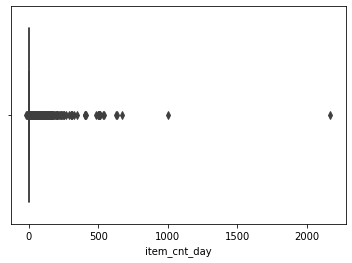

In [ ]:
sns.boxplot(x=sales.item_cnt_day)

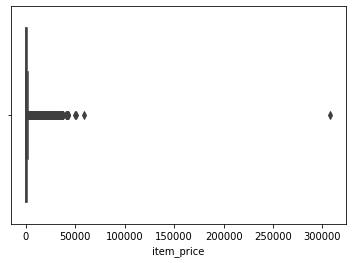

In [ ]:
sns.boxplot(x=sales.item_price)

In [ ]:
train = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 1001] #이상치 제거

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
print(shops[shops.shop_id.isin([0, 57])]['shop_name'])
print(shops[shops.shop_id.isin([1, 58])]['shop_name'])
print(shops[shops.shop_id.isin([40, 39])]['shop_name'])
#shop name이 같은데 shop id가 다른 경우

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


In [ ]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
  #current state of shops and items
  # product of (shop_id) * (cur_items) * (block_num)
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df

[array([[   59, 22154,     0],
        [   59,  2552,     0],
        [   59,  2554,     0],
        ...,
        [   45,   628,     0],
        [   45,   631,     0],
        [   45,   621,     0]], dtype=int32), array([[   50,  3880,     1],
        [   50,  4128,     1],
        [   50,  4124,     1],
        ...,
        [   28, 12885,     1],
        [   28, 12791,     1],
        [   28, 13433,     1]], dtype=int32), array([[    5, 20175,     2],
        [    5, 20083,     2],
        [    5,    31,     2],
        ...,
        [    4, 12388,     2],
        [    4, 12340,     2],
        [    4, 10649,     2]], dtype=int32), array([[   25,  8092,     3],
        [   25,  7850,     3],
        [   25,  8051,     3],
        ...,
        [   41, 14063,     3],
        [   41, 20690,     3],
        [   41, 19235,     3]], dtype=int32), array([[   59, 22114,     4],
        [   59, 20239,     4],
        [   59, 20238,     4],
        ...,
        [    6,  1924,     4],
        [  

In [ ]:
df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

In [ ]:
df

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
...,...,...,...
10842072,21,7635,33
10842073,21,7638,33
10842074,21,7640,33
10842075,21,7632,33


In [ ]:
#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [ ]:
#Add holiday cnt
group = train.groupby(['date_block_num']).agg({'holiday': ['sum']})
group.columns = ['holiday_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num'], how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .astype(np.int64))
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month
0,59,22154,0,1,39702
1,59,2552,0,0,39702
2,59,2554,0,0,39702
3,59,2555,0,0,39702
4,59,2564,0,0,39702
...,...,...,...,...,...
10842072,21,7635,33,0,0
10842073,21,7638,33,0,0
10842074,21,7640,33,0,0
10842075,21,7632,33,0,0


In [ ]:
# 월 별 item이 팔린 종류 count
group = train.groupby(['date_block_num']).agg({'item_id': ['count']})
group.columns = ['month_item']
group.reset_index(inplace=True)

In [ ]:
df = pd.merge(df, group, on=['date_block_num'], how='left')
df['month_item'] = (df['month_item']
                                .fillna(0)
                                .astype(np.int64))

In [ ]:
#월, shop 별 item이 팔린 종류
group = train.groupby(['date_block_num', 'shop_id']).agg({'item_id': ['count']})
group.columns = ['month_shop']
group.reset_index(inplace=True)

In [ ]:
df = pd.merge(df, group, on=['date_block_num', 'shop_id'], how='left')
df['month_shop'] = (df['month_shop']
                                .fillna(0)
                                .astype(np.int64))
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,month_item,month_shop
0,59,22154,0,1,39702,115690,1847
1,59,2552,0,0,39702,115690,1847
2,59,2554,0,0,39702,115690,1847
3,59,2555,0,0,39702,115690,1847
4,59,2564,0,0,39702,115690,1847
...,...,...,...,...,...,...,...
10842072,21,7635,33,0,0,53513,1567
10842073,21,7638,33,0,0,53513,1567
10842074,21,7640,33,0,0,53513,1567
10842075,21,7632,33,0,0,53513,1567


In [ ]:
df = df.drop(columns = ['month_shop'])

In [ ]:
#holiday 대비 팔린 item 종류의 비율
df['holiday_month'] = df['holiday_month'] / df['month_item']
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,month_item
0,59,22154,0,1,0.343176,115690
1,59,2552,0,0,0.343176,115690
2,59,2554,0,0,0.343176,115690
3,59,2555,0,0,0.343176,115690
4,59,2564,0,0,0.343176,115690
...,...,...,...,...,...,...
10842072,21,7635,33,0,0.000000,53513
10842073,21,7638,33,0,0.000000,53513
10842074,21,7640,33,0,0.000000,53513
10842075,21,7632,33,0,0.000000,53513


In [ ]:
df = df.drop(columns = ['month_item'])

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)

test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [ ]:
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

In [ ]:
import gc

del group
del holiday
del test
gc.collect()

0



---
Feature Engineering


In [ ]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,якутск,29
2,"Адыгея ТЦ ""Мега""",2,адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,вологда,3
6,"Воронеж (Плехановская, 13)",6,воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,воронеж,4
9,Выездная Торговля,9,выездная,5


In [ ]:
#각 도시별 위도와 경도, clustering
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

In [ ]:
shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]
shops

,shop_id,city_code,city_coord_1,city_coord_2,country_part
0,0,29,62.028098,129.732555,4
1,1,29,62.028098,129.732555,4
2,2,0,44.609764,40.100516,3
3,3,1,55.809450,37.958060,1
4,4,2,53.430580,50.119000,3
5,5,3,59.223900,39.883980,2
6,6,4,51.672040,39.184300,3
7,7,4,51.672040,39.184300,3
8,8,4,51.672040,39.184300,3
9,9,5,0.000000,0.000000,0


In [ ]:
df = pd.merge(df, shops, on=['shop_id'], how='left')
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2
...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4


In [ ]:
items = pd.merge(items, item_cats, on='item_category_id')
items

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


In [ ]:
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])

map_dict = { #같은 item category 묶기
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

#item category 대분류
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

#item category 소분류
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])

items = items[['item_id', 'item_category_common', 'item_category_code']]

In [ ]:
df = pd.merge(df, items, on=['item_id'], how='left')
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2,11,37
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,56
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,59
...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4,13,55
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4,14,64
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4,13,55
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4,11,40


In [ ]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

In [ ]:
weeknd_count = len([1 for i in calendar.monthcalendar(2013, 3) if i[6] != 0]) #i[6] = stop
for i in calendar.monthcalendar(2013,1):
  print(i)

[0, 1, 2, 3, 4, 5, 6]
[7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19, 20]
[21, 22, 23, 24, 25, 26, 27]
[28, 29, 30, 31, 0, 0, 0]


In [ ]:
map_dict = {i: count_days(i) for i in range(35)}

In [ ]:
df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [ ]:
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block #item의 첫출시 

,item_id,date_block_num
0,0,20
1,1,15
2,2,19
3,3,18
4,4,20
...,...,...
22164,22165,7
22165,22166,9
22166,22167,8
22167,22168,0


In [ ]:
first_item_block['item_first_interaction'] = 1
first_item_block

,item_id,date_block_num,item_first_interaction
0,0,20,1
1,1,15,1
2,2,19,1
3,3,18,1
4,4,20,1
...,...,...,...
22164,22165,7,1
22165,22166,9,1
22166,22167,8,1
22167,22168,0,1


In [ ]:
first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']
first_shop_item_buy_block #새롭게 출시된 item이 처음 팔린 달

,shop_id,item_id,date_block_num,first_date_block_num
0,2,0,20,20
1,2,1,15,15
2,2,2,19,19
3,2,3,18,18
4,2,4,20,20
...,...,...,...,...
1105936,59,22165,7,7
1105937,59,22166,9,9
1105938,59,22167,8,8
1105939,59,22168,1,1


In [ ]:
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,first_date_block_num
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2,11,37,4,31,1.0,1.0
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1.0,3.0
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1.0,NaN
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,56,4,31,1.0,1.0
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,59,4,31,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4,13,55,5,30,NaN,23.0
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4,14,64,5,30,NaN,32.0
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4,13,55,5,30,NaN,1.0
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4,11,40,5,30,NaN,23.0


In [ ]:
df['first_date_block_num'].fillna(100, inplace=True) #max값 삽입
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True) #상품이 전에 팔렸는지 확인
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2,11,37,4,31,1.0,0
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1.0,0
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1.0,0
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,56,4,31,1.0,0
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,59,4,31,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4,13,55,5,30,NaN,1
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4,14,64,5,30,NaN,1
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4,13,55,5,30,NaN,1
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4,11,40,5,30,NaN,1


In [ ]:
df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)

df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

In [ ]:
def lag_feature(df, lags, col): #shift date_block_num
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

In [ ]:
#Add sales lags for last 3 months
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

In [ ]:
#Add avg shop/item price: 월, shop, item별 매출 평균
index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

In [ ]:
# 월, item별 매출 평균
index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

In [ ]:
# (shop item 매출 - item 전체 매출)/item 전체 매출 => item별 shop의 매출 비율
df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2,11,37,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4,13,55,5,30,0,1,1.0,0.0,0.0,0.0,-1.0,-1.0
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4,14,64,5,30,0,1,0.0,0.0,NaN,-1.0,-1.0,NaN
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4,13,55,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4,11,40,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0


In [ ]:
#월, item별 판매량 평균
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3
0,59,22154,0,1.0,0.343176,0.0,30,57.62987,39.87368,2,11,37,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.343176,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,0.000000,214195.0,19,53.20007,50.15000,4,13,55,5,30,0,1,1.0,0.0,0.0,0.0,-1.0,-1.0,0.045441,0.023254,0.071411
11056273,45,16188,34,0.0,0.000000,214196.0,19,53.20007,50.15000,4,14,64,5,30,0,1,0.0,0.0,NaN,-1.0,-1.0,NaN,0.022720,0.069763,NaN
11056274,45,15757,34,0.0,0.000000,214197.0,19,53.20007,50.15000,4,13,55,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.113647,0.069763,0.095215
11056275,45,19648,34,0.0,0.000000,214198.0,19,53.20007,50.15000,4,11,40,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.045441,0.069763,0.166626


In [ ]:
#item, 도시별 월평균 판매량
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [ ]:
#item, shop별 월평균 판매량
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.drop(['item_shop_target_enc'], axis=1, inplace=True)

In [ ]:
#새롭게 출시된 item의 item category별 월평균 판매량
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

In [ ]:
#새롭게 출시된 item의 shop, item category별 월평균 판매량
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

Add sales for the last three months for similar item (item with id = item_id - 1; kinda tricky feature, but increased the metric significantly)

In [ ]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

In [ ]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)] #lag data를 3개월 사용했으므로 0,1,2 date_block_num 삭제
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,holiday_month,ID,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_target_enc_lag_1,item_target_enc_lag_2,item_target_enc_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
1122795,25,8092,3,3.0,0.0,0.0,13,55.75222,37.61556,1,11,40,4,30,0,1,1.0,0.0,4.0,0.019669,-1.000000,0.047455,0.586914,0.630371,1.444336,0.666504,0.666504,2.000000,1.0,0.0,4.0,0.643066,0.517578,0.293945,1.996094,1.446289,0.891113,7.0,5.0,13.0
1122796,25,7850,3,3.0,0.0,0.0,13,55.75222,37.61556,1,8,30,4,30,0,1,5.0,1.0,6.0,0.014656,0.025116,0.023132,1.869141,1.456055,3.089844,2.916016,2.083984,2.916016,5.0,1.0,6.0,3.351562,0.745605,1.126953,4.867188,0.898438,1.947266,0.0,0.0,0.0
1122797,25,8051,3,3.0,0.0,0.0,13,55.75222,37.61556,1,14,66,4,30,0,1,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,0.043488,0.130493,0.133301,0.000000,0.333252,0.333252,0.0,0.0,0.0,0.027664,0.036224,0.160645,0.000000,0.416748,1.019531,0.0,0.0,0.0
1122798,25,8088,3,1.0,0.0,0.0,13,55.75222,37.61556,1,13,55,4,30,0,1,1.0,1.0,0.0,0.000000,0.283936,-1.000000,0.130493,0.043488,0.066650,0.166626,0.083313,0.000000,1.0,1.0,0.0,0.333252,0.108521,0.208130,1.000000,0.303955,0.534668,0.0,1.0,0.0
1122799,25,8089,3,1.0,0.0,0.0,13,55.75222,37.61556,1,13,55,4,30,0,1,0.0,1.0,0.0,-1.000000,0.038483,-1.000000,0.478271,0.260986,0.177734,0.666504,0.250000,0.083313,0.0,1.0,0.0,0.333252,0.108521,0.208130,1.000000,0.303955,0.534668,2.0,0.0,3.0


In [ ]:
#Save dataset
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('df.pkl')

In [ ]:
import gc
del df
del group
del items
del shops
del item_cats
del train
gc.collect()

12

In [ ]:
df = pd.read_pickle('df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933482 entries, 1122795 to 11056276
Data columns (total 36 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int32  
 1   item_id                      int32  
 2   date_block_num               int32  
 3   item_cnt_month               float64
 4   holiday_month                float64
 5   city_code                    int64  
 6   item_category_common         int64  
 7   item_category_code           int64  
 8   weeknd_count                 int64  
 9   days_in_month                int64  
 10  item_first_interaction       int8   
 11  shop_item_sold_before        int8   
 12  item_cnt_month_lag_1         float16
 13  item_cnt_month_lag_2         float16
 14  item_cnt_month_lag_3         float16
 15  item_shop_price_avg_lag_1    float16
 16  item_shop_price_avg_lag_2    float16
 17  item_shop_price_avg_lag_3    float16
 18  item_target_enc_lag_1        float1

In [ ]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

In [ ]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        #'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

In [ ]:
lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

In [ ]:
evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.20337	valid_1's rmse: 1.12703
[10]	training's rmse: 1.19083	valid_1's rmse: 1.11738
[15]	training's rmse: 1.17857	valid_1's rmse: 1.10825
[20]	training's rmse: 1.16689	valid_1's rmse: 1.09958
[25]	training's rmse: 1.15602	valid_1's rmse: 1.09156
[30]	training's rmse: 1.14535	valid_1's rmse: 1.08357
[35]	training's rmse: 1.13487	valid_1's rmse: 1.07572
[40]	training's rmse: 1.12501	valid_1's rmse: 1.06828
[45]	training's rmse: 1.11525	valid_1's rmse: 1.06099
[50]	training's rmse: 1.10595	valid_1's rmse: 1.05405
[55]	training's rmse: 1.09684	valid_1's rmse: 1.04753
[60]	training's rmse: 1.088	valid_1's rmse: 1.04097
[65]	training's rmse: 1.07966	valid_1's rmse: 1.03482
[70]	training's rmse: 1.07167	valid_1's rmse: 1.029
[75]	training's rmse: 1.06386	valid_1's rmse: 1.02344
[80]	training's rmse: 1.05651	valid_1's rmse: 1.01819
[85]	training's rmse: 1.04909	valid_1's rmse: 1.01313
[90]	training's rmse: 1.

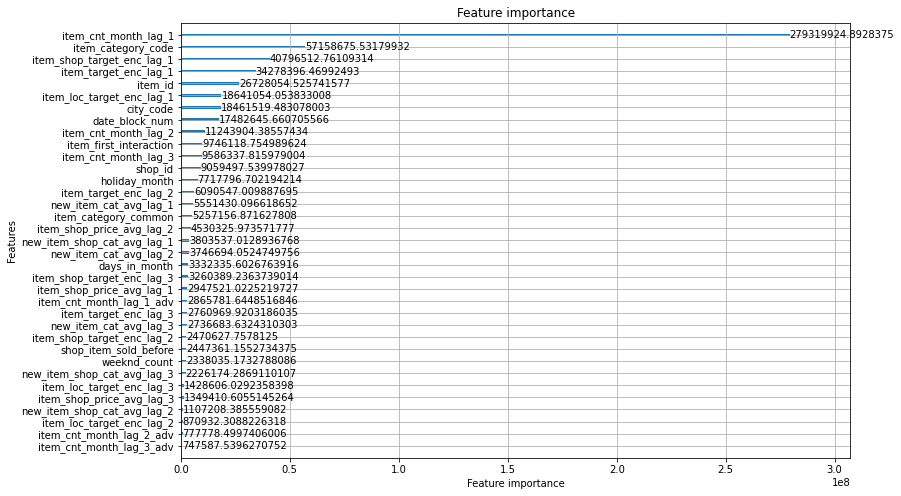

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8))

In [ ]:
test = pd.read_csv('test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission.csv', index=False)